In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
from tqdm.notebook import tqdm
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torchmetrics
from torchmetrics import Metric
import torchvision
from torchvision import models
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

device = 'cuda' if torch.cuda.is_available() else 'cpu'

np.__version__, device

('2.2.4', 'cuda')

In [2]:
TRAIN_PATH = 'dataset\Train'
TEST_PATH = 'dataset\Test'

def load_data(PATH):
    filenames, fruit, fresh = [], [], []
    
    for file in tqdm(os.listdir(PATH)):
        for img in os.listdir(os.path.join(PATH, file)):
            fresh.append(0 if file[0] == 'f' else 1)
            fruit.append(file[5:] if file[0] == 'f' else file[6: ])
            filenames.append(os.path.join(PATH, file, img))
            
    df = pd.DataFrame({
        'filename' : filenames,
        'fruit' : fruit,
        'fresh' : fresh
    })
    
    return df

df_train = load_data(TRAIN_PATH).sample(frac = 1)
df_test = load_data(TEST_PATH).sample(frac = 1)

df_train.shape, df_test.shape

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

((21044, 3), (6368, 3))

In [3]:
df_train.drop(df_train[(df_train['fruit'] == 'capsicum') | (df_train['fruit'] == 'bittergroud') | (df_train['fruit'] == 'okra') | (df_train['fruit'] == 'oranges') | (df_train['fruit'] == 'cucumber')].index, inplace = True)
df_test['fruit'] = df_test['fruit'].map(lambda x : 'tomato' if x == 'tamto' else x)
df_test['fruit'] = df_test['fruit'].map(lambda x : 'potato' if x == 'patato' else x)
df_test.drop(df_test[(df_test['fruit'] == 'okra') | (df_test['fruit'] == 'oranges') | (df_test['fruit'] == 'cucumber')].index, inplace = True)

In [4]:
df = pd.concat([df_train, df_test], axis = 0)
df.shape

(20542, 3)

<Axes: xlabel='fruit', ylabel='count'>

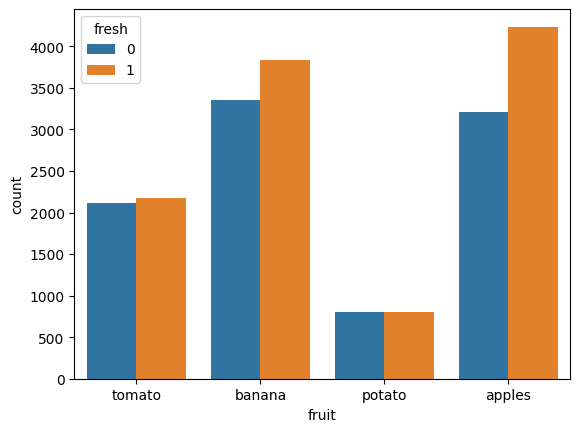

In [5]:
sea.countplot(x = 'fruit', data = df, hue = 'fresh')

In [6]:
counts = df['fruit'].value_counts()
counts

fruit
apples    7451
banana    7192
tomato    4291
potato    1608
Name: count, dtype: int64

In [7]:
balanced_df = pd.DataFrame(columns= ['filename', 'fruit', 'fresh'])
for (key, value) in counts.items():
    if value > 1978:
        df_temp = df[df['fruit'] == key].sample(n = 1978)
    else:
        df_temp = df[df['fruit'] == key]
        
    balanced_df = pd.concat([balanced_df, df_temp], axis = 0)  
    
balanced_df.shape

(7542, 3)

In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

balanced_df['fruit_label'] = le.fit_transform(balanced_df['fruit'])
balanced_df.shape


(7542, 4)

In [11]:
balanced_df.head()

,filename,fruit,fresh,fruit_label
3426,dataset\Test\rottenapples\a_r182.png,apples,1,0
3616,dataset\Test\rottenapples\a_r372.png,apples,1,0
11105,dataset\Train\rottenapples\rotated_by_30_Scree...,apples,1,0
152,dataset\Test\freshapples\a_f153.png,apples,0,0
11611,dataset\Train\rottenapples\rotated_by_60_Scree...,apples,1,0


In [9]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(balanced_df, test_size = 0.15, stratify = balanced_df['fruit_label'])

df_train.shape, df_val.shape

((6410, 4), (1132, 4))

In [10]:
def image_transform(img, p = 0.5, training = True):    
    if training:
        img = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p = p),
            transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
            transforms.RandomAdjustSharpness(3, p = p),
            transforms.Normalize(mean = 0, std = 1)
        ])(img)
    else:
        img = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize(mean = 0, std = 1)
        ])(img)

    return img

class FruitDataset:
    def __init__(self, df, training):
        self.df = df
        self.n_samples = len(self.df)
        self.training = training
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        # Используем iloc с двумя индексами: сначала строка, затем позиция столбца
        img = plt.imread(self.df.iloc[idx, 0])[:, :, :3]
        fresh = torch.tensor(self.df.iloc[idx, 2])
        fruit = torch.tensor(self.df.iloc[idx, 3])

        img = image_transform(img, p = 0.5, training = self.training)
            
        return img, fruit, fresh

In [11]:
BATCH_SIZE = 64


train_dataset = FruitDataset(df_train, training = True)
val_dataset = FruitDataset(df_val, training = False)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)

In [16]:
class SimpleCNN(nn.Module):
    def __init__(self, num_fruits=7, num_states=2):
        super(SimpleCNN, self).__init__()
        # Сверточные слои
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Полносвязные слои для обеих задач
        # Предполагаем, что размер изображения 224x224, после трёх блоков MaxPool (каждый уменьшает размер в 2 раза) получим 28x28
        self.fc_input_dim = 128 * 28 * 28
        
        # Голова для классификации типа фрукта
        self.fc_fruit = nn.Sequential(
            nn.Linear(self.fc_input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, num_fruits)
        )
        
        # Голова для классификации состояния
        self.fc_state = nn.Sequential(
            nn.Linear(self.fc_input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, num_states)
        )
        
        # Слой подвыборки
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        # Сверточная часть
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        # Разворачиваем в вектор
        x = x.view(x.size(0), -1)
        
        # Параллельное предсказание двух задач
        fruit_logits = self.fc_fruit(x)
        state_logits = self.fc_state(x)
        return fruit_logits, state_logits

# Пример использования модели:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_fruits=7, num_states=2).to(device)

# Пример входного изображения (batch_size=1, 3x224x224)
dummy_input = torch.randn(1, 3, 224, 224).to(device)
fruit_pred, state_pred = model(dummy_input)

print("Логиты для типа фрукта:", fruit_pred)
print("Логиты для состояния:", state_pred)

Логиты для типа фрукта: tensor([[-0.0287, -0.0252, -0.0540,  0.1007, -0.0068,  0.0019,  0.0633]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
Логиты для состояния: tensor([[ 0.0701, -0.0602]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [17]:
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Определяем устройство и отправляем модель на него
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Задаём оптимизатор и функцию потерь (например, CrossEntropyLoss для обеих задач)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

num_epochs = 5  # можно задать нужное количество эпох

# Цикл обучения
# Инициализация списков для сохранения метрик
train_losses = []
train_fruit_accs = []
train_fresh_accs = []
val_losses = []
val_fruit_accs = []
val_fresh_accs = []

for epoch in range(num_epochs):
    # Тренировочная фаза
    model.train()
    running_loss = 0.0
    running_fruit_acc = 0.0
    running_fresh_acc = 0.0
    
    for batch_idx, (imgs, fruit_labels, fresh_labels) in enumerate(train_loader):
        imgs = imgs.to(device)
        fruit_labels = fruit_labels.to(device)
        fresh_labels = fresh_labels.to(device)
        
        optimizer.zero_grad()
        
        fruit_logits, fresh_logits = model(imgs)
        loss_fruit = criterion(fruit_logits, fruit_labels)
        loss_fresh = criterion(fresh_logits, fresh_labels)
        loss = loss_fruit + loss_fresh
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Вычисление точности
        fruit_preds = torch.argmax(fruit_logits, dim=1)
        fresh_preds = torch.argmax(fresh_logits, dim=1)
        batch_fruit_acc = (fruit_preds == fruit_labels).float().mean().item()
        batch_fresh_acc = (fresh_preds == fresh_labels).float().mean().item()
        running_fruit_acc += batch_fruit_acc
        running_fresh_acc += batch_fresh_acc
        
        if (batch_idx + 1) % 64 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], "
                  f"Loss: {loss.item():.4f}, Fruit Acc: {batch_fruit_acc:.4f}, Fresh Acc: {batch_fresh_acc:.4f}")
    
    # Сохранение тренировочных метрик
    epoch_loss = running_loss / len(train_loader)
    epoch_fruit_acc = running_fruit_acc / len(train_loader)
    epoch_fresh_acc = running_fresh_acc / len(train_loader)
    train_losses.append(epoch_loss)
    train_fruit_accs.append(epoch_fruit_acc)
    train_fresh_accs.append(epoch_fresh_acc)
    
    # Валидационная фаза
    model.eval()
    val_running_loss = 0.0
    val_running_fruit_acc = 0.0
    val_running_fresh_acc = 0.0
    
    with torch.no_grad():
        for imgs, fruit_labels, fresh_labels in val_loader:
            imgs = imgs.to(device)
            fruit_labels = fruit_labels.to(device)
            fresh_labels = fresh_labels.to(device)
            
            fruit_logits, fresh_logits = model(imgs)
            loss_fruit = criterion(fruit_logits, fruit_labels)
            loss_fresh = criterion(fresh_logits, fresh_labels)
            loss = loss_fruit + loss_fresh
            
            val_running_loss += loss.item()
            
            fruit_preds = torch.argmax(fruit_logits, dim=1)
            fresh_preds = torch.argmax(fresh_logits, dim=1)
            val_running_fruit_acc += (fruit_preds == fruit_labels).float().mean().item()
            val_running_fresh_acc += (fresh_preds == fresh_labels).float().mean().item()
    
    # Сохранение валидационных метрик
    val_epoch_loss = val_running_loss / len(val_loader)
    val_epoch_fruit_acc = val_running_fruit_acc / len(val_loader)
    val_epoch_fresh_acc = val_running_fresh_acc / len(val_loader)
    val_losses.append(val_epoch_loss)
    val_fruit_accs.append(val_epoch_fruit_acc)
    val_fresh_accs.append(val_epoch_fresh_acc)
    
    # Вывод информации об эпохе
    print(f"Epoch [{epoch+1}/{num_epochs}] завершена\n"
          f"Train Loss: {epoch_loss:.4f}, Fruit Acc: {epoch_fruit_acc:.4f}, Fresh Acc: {epoch_fresh_acc:.4f}\n"
          f"Val Loss: {val_epoch_loss:.4f}, Fruit Acc: {val_epoch_fruit_acc:.4f}, Fresh Acc: {val_epoch_fresh_acc:.4f}\n")

# Оценка на валидационном наборе
model.eval()

d:\Projects\University courseworks\ML5\env\Lib\site-packages\torchvision\transforms\functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:209.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


Epoch [1/5], Batch [64/101], Loss: 0.7678, Fruit Acc: 0.9062, Fresh Acc: 0.6719
Epoch [1/5] завершена
Train Loss: 1.0113, Fruit Acc: 0.8233, Fresh Acc: 0.7169
Val Loss: 0.7394, Fruit Acc: 0.9428, Fresh Acc: 0.7214

Epoch [2/5], Batch [64/101], Loss: 0.4815, Fruit Acc: 0.9844, Fresh Acc: 0.7656
Epoch [2/5] завершена
Train Loss: 0.5309, Fruit Acc: 0.9587, Fresh Acc: 0.8087
Val Loss: 0.5448, Fruit Acc: 0.9454, Fresh Acc: 0.7812

Epoch [3/5], Batch [64/101], Loss: 0.3072, Fruit Acc: 0.9844, Fresh Acc: 0.8906
Epoch [3/5] завершена
Train Loss: 0.4214, Fruit Acc: 0.9700, Fresh Acc: 0.8558
Val Loss: 0.4021, Fruit Acc: 0.9701, Fresh Acc: 0.8613

Epoch [4/5], Batch [64/101], Loss: 0.5084, Fruit Acc: 0.9531, Fresh Acc: 0.8594
Epoch [4/5] завершена
Train Loss: 0.3524, Fruit Acc: 0.9766, Fresh Acc: 0.8766
Val Loss: 0.3424, Fruit Acc: 0.9766, Fresh Acc: 0.8774

Epoch [5/5], Batch [64/101], Loss: 0.3375, Fruit Acc: 0.9844, Fresh Acc: 0.9062
Epoch [5/5] завершена
Train Loss: 0.2979, Fruit Acc: 0.9802,

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc_fruit): Sequential(
    (0): Linear(in_features=100352, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=7, bias=True)
  )
  (fc_state): Sequential(
    (0): Linear(in_features=100352, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2, bias=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [18]:
all_fruit_preds = []
all_fruit_true = []
all_fresh_preds = []
all_fresh_true = []

with torch.no_grad():
    for imgs, fruit_labels, fresh_labels in val_loader:
        imgs = imgs.to(device)
        fruit_labels = fruit_labels.to(device)
        fresh_labels = fresh_labels.to(device)
        
        fruit_logits, fresh_logits = model(imgs)
        
        # Получаем предсказания (индексы наибольшего логита)
        fruit_preds = torch.argmax(fruit_logits, dim=1)
        fresh_preds = torch.argmax(fresh_logits, dim=1)
        
        all_fruit_preds.extend(fruit_preds.cpu().numpy())
        all_fruit_true.extend(fruit_labels.cpu().numpy())
        all_fresh_preds.extend(fresh_preds.cpu().numpy())
        all_fresh_true.extend(fresh_labels.cpu().numpy())

# Вычисление метрик для классификации фруктов
print("=== Метрики для классификации типа фрукта ===")
fruit_acc = accuracy_score(all_fruit_true, all_fruit_preds)
print("Accuracy:", fruit_acc)
print("Confusion Matrix:")
print(confusion_matrix(all_fruit_true, all_fruit_preds))
print("\nClassification Report:")
print(classification_report(all_fruit_true, all_fruit_preds))

# Вычисление метрик для классификации состояния
print("\n=== Метрики для классификации состояния (fresh/spoiled) ===")
fresh_acc = accuracy_score(all_fresh_true, all_fresh_preds)
print("Accuracy:", fresh_acc)
print("Confusion Matrix:")
print(confusion_matrix(all_fresh_true, all_fresh_preds))
print("\nClassification Report:")
print(classification_report(all_fresh_true, all_fresh_preds))

=== Метрики для классификации типа фрукта ===
Accuracy: 0.9699646643109541
Confusion Matrix:
[[277  16   0   4]
 [  3 294   0   0]
 [  0   0 241   0]
 [  1   6   4 286]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       297
           1       0.93      0.99      0.96       297
           2       0.98      1.00      0.99       241
           3       0.99      0.96      0.97       297

    accuracy                           0.97      1132
   macro avg       0.97      0.97      0.97      1132
weighted avg       0.97      0.97      0.97      1132


=== Метрики для классификации состояния (fresh/spoiled) ===
Accuracy: 0.8798586572438163
Confusion Matrix:
[[445  87]
 [ 49 551]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       532
           1       0.86      0.92      0.89       600

    accuracy                           0.88      113

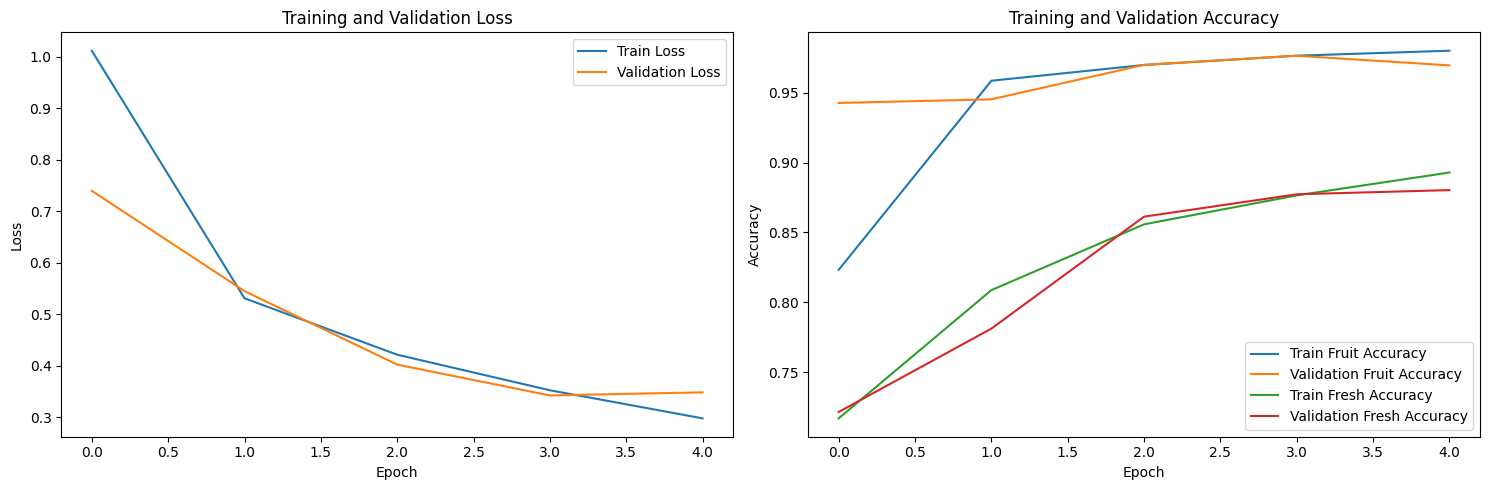

In [19]:
# Визуализация графиков обучения
plt.figure(figsize=(15, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(train_fruit_accs, label='Train Fruit Accuracy')
plt.plot(val_fruit_accs, label='Validation Fruit Accuracy')
plt.plot(train_fresh_accs, label='Train Fresh Accuracy')
plt.plot(val_fresh_accs, label='Validation Fresh Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
class MultiTaskModel(nn.Module):
    def __init__(self, backbone, num_fruit_classes, num_freshness_classes):
        """
        backbone: предобученная модель из torchvision или иного источника.
        num_fruit_classes: число классов для задачи классификации типа фрукта/овоща.
        num_freshness_classes: число классов для задачи классификации свежести (например, 2).
        """
        super(MultiTaskModel, self).__init__()
        
        self.backbone = backbone
        
        # Обработка backbone для извлечения признаков
        # Если backbone имеет атрибут fc (например, ResNet)
        if hasattr(self.backbone, 'fc'):
            in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()  # убираем последний классификатор
        # Если backbone имеет атрибут classifier (например, EfficientNet или MobileNetV3)
        elif hasattr(self.backbone, 'classifier'):
            if isinstance(self.backbone.classifier, nn.Sequential):
                classifier_len = len(self.backbone.classifier)
                if classifier_len == 2:
                    # Пример для EfficientNetB3: [Dropout, Linear]
                    in_features = self.backbone.classifier[1].in_features
                elif classifier_len in [3, 4]:
                    # Пример для MobileNetV3: [Linear, Hardswish, (Dropout), Linear]
                    in_features = self.backbone.classifier[0].in_features
                else:
                    raise ValueError(f"Неожиданная длина classifier: ожидается 2, 3 или 4 элемента, получено {classifier_len}.")
                self.backbone.classifier = nn.Identity()
            else:
                in_features = self.backbone.classifier.in_features
                self.backbone.classifier = nn.Identity()
        else:
            raise ValueError("Неподдерживаемая модель backbone")
        
        # Голова для классификации фрукта/овоща
        self.fruit_head = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Linear(512, num_fruit_classes)
        )
        
        # Голова для классификации свежести
        self.fresh_head = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Linear(512, num_freshness_classes)
        )
    
    def forward(self, x):
        # Извлекаем признаки из backbone
        features = self.backbone(x)
        # Получаем предсказания для двух задач
        fruit_logits = self.fruit_head(features)
        fresh_logits = self.fresh_head(features)
        return fruit_logits, fresh_logits

In [13]:
# Функции для заморозки и разморозки весов backbone
def freeze_backbone(model):
    for param in model.backbone.parameters():
        param.requires_grad = False

def unfreeze_backbone(model, last_n_layers=None):
    if last_n_layers is None:
        for param in model.backbone.parameters():
            param.requires_grad = True
    else:
        # Пример: получить список слоёв и разморозить последние N слоёв
        layers = list(model.backbone.children())
        for layer in layers[-last_n_layers:]:
            for param in layer.parameters():
                param.requires_grad = True

In [14]:
def train_model(model, train_loader, val_loader, device, num_epochs=5, frozen_epochs=3):
    # Определяем критерий как CrossEntropyLoss для обеих задач
    criterion = nn.CrossEntropyLoss()
    
    # Сначала обучаем только головы, поэтому параметры backbone заморожены
    freeze_backbone(model)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
    
    train_losses = []
    train_fruit_accs = []
    train_fresh_accs = []
    val_losses = []
    val_fruit_accs = []
    val_fresh_accs = []
    
    for epoch in range(num_epochs):
        print(f"Эпоха {epoch+1}/{num_epochs}")
        
        # Если прошло заданное число эпох с замороженными слоями, размораживаем backbone и пересоздаём оптимизатор
        if epoch == frozen_epochs:
            print("Разморозка весов backbone...")
            unfreeze_backbone(model)
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        
        # --- Тренировочная фаза ---
        model.train()
        running_loss = 0.0
        running_fruit_acc = 0.0
        running_fresh_acc = 0.0
        
        for batch_idx, (imgs, fruit_labels, fresh_labels) in enumerate(tqdm(train_loader, desc="Train batches")):
            imgs = imgs.to(device)
            fruit_labels = fruit_labels.to(device)
            fresh_labels = fresh_labels.to(device)
            
            optimizer.zero_grad()
            
            fruit_logits, fresh_logits = model(imgs)
            loss_fruit = criterion(fruit_logits, fruit_labels)
            loss_fresh = criterion(fresh_logits, fresh_labels)
            loss = loss_fruit + loss_fresh
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Вычисляем точность для текущего батча
            fruit_preds = torch.argmax(fruit_logits, dim=1)
            fresh_preds = torch.argmax(fresh_logits, dim=1)
            batch_fruit_acc = (fruit_preds == fruit_labels).float().mean().item()
            batch_fresh_acc = (fresh_preds == fresh_labels).float().mean().item()
            running_fruit_acc += batch_fruit_acc
            running_fresh_acc += batch_fresh_acc
        
        epoch_loss = running_loss / len(train_loader)
        epoch_fruit_acc = running_fruit_acc / len(train_loader)
        epoch_fresh_acc = running_fresh_acc / len(train_loader)
        train_losses.append(epoch_loss)
        train_fruit_accs.append(epoch_fruit_acc)
        train_fresh_accs.append(epoch_fresh_acc)
        print(f"Train Loss: {epoch_loss:.4f}, Fruit Acc: {epoch_fruit_acc:.4f}, Fresh Acc: {epoch_fresh_acc:.4f}")
        
        # --- Валидационная фаза ---
        model.eval()
        val_running_loss = 0.0
        val_running_fruit_acc = 0.0
        val_running_fresh_acc = 0.0
        
        with torch.no_grad():
            for imgs, fruit_labels, fresh_labels in tqdm(val_loader, desc="Val batches"):
                imgs = imgs.to(device)
                fruit_labels = fruit_labels.to(device)
                fresh_labels = fresh_labels.to(device)
                
                fruit_logits, fresh_logits = model(imgs)
                loss_fruit = criterion(fruit_logits, fruit_labels)
                loss_fresh = criterion(fresh_logits, fresh_labels)
                loss = loss_fruit + loss_fresh
                
                val_running_loss += loss.item()
                
                fruit_preds = torch.argmax(fruit_logits, dim=1)
                fresh_preds = torch.argmax(fresh_logits, dim=1)
                val_running_fruit_acc += (fruit_preds == fruit_labels).float().mean().item()
                val_running_fresh_acc += (fresh_preds == fresh_labels).float().mean().item()
        
        val_epoch_loss = val_running_loss / len(val_loader)
        val_epoch_fruit_acc = val_running_fruit_acc / len(val_loader)
        val_epoch_fresh_acc = val_running_fresh_acc / len(val_loader)
        val_losses.append(val_epoch_loss)
        val_fruit_accs.append(val_epoch_fruit_acc)
        val_fresh_accs.append(val_epoch_fresh_acc)
        print(f"Val Loss: {val_epoch_loss:.4f}, Fruit Acc: {val_epoch_fruit_acc:.4f}, Fresh Acc: {val_epoch_fresh_acc:.4f}\n")
    
    return {
        'train_loss': train_losses,
        'train_fruit_acc': train_fruit_accs,
        'train_fresh_acc': train_fresh_accs,
        'val_loss': val_losses,
        'val_fruit_acc': val_fruit_accs,
        'val_fresh_acc': val_fresh_accs
    }

In [15]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_fruit_labels = []
    all_fruit_preds = []
    all_fresh_labels = []
    all_fresh_preds = []
    
    with torch.no_grad():
        for imgs, fruit_labels, fresh_labels in tqdm(test_loader, desc="Test batches"):
            imgs = imgs.to(device)
            fruit_labels = fruit_labels.to(device)
            fresh_labels = fresh_labels.to(device)
            
            fruit_logits, fresh_logits = model(imgs)
            fruit_preds = torch.argmax(fruit_logits, dim=1)
            fresh_preds = torch.argmax(fresh_logits, dim=1)
            
            all_fruit_labels.extend(fruit_labels.cpu().numpy())
            all_fruit_preds.extend(fruit_preds.cpu().numpy())
            all_fresh_labels.extend(fresh_labels.cpu().numpy())
            all_fresh_preds.extend(fresh_preds.cpu().numpy())
    
    # Расчёт метрик для классификации типа фрукта/овоща
    fruit_acc = accuracy_score(all_fruit_labels, all_fruit_preds)
    fruit_recall = recall_score(all_fruit_labels, all_fruit_preds, average='macro')
    fruit_f1 = f1_score(all_fruit_labels, all_fruit_preds, average='macro')
    fruit_cm = confusion_matrix(all_fruit_labels, all_fruit_preds)
    
    # Метрики для классификации свежести
    fresh_acc = accuracy_score(all_fresh_labels, all_fresh_preds)
    fresh_recall = recall_score(all_fresh_labels, all_fresh_preds, average='macro')
    fresh_f1 = f1_score(all_fresh_labels, all_fresh_preds, average='macro')
    fresh_cm = confusion_matrix(all_fresh_labels, all_fresh_preds)
    
    print("Метрики для классификации фруктов/овощей:")
    print(f"Точность: {fruit_acc:.4f}")
    print(f"Полнота: {fruit_recall:.4f}")
    print(f"F1-score: {fruit_f1:.4f}")
    print("Матрица ошибок:")
    print(fruit_cm)
    
    print("\nМетрики для классификации свежести:")
    print(f"Точность: {fresh_acc:.4f}")
    print(f"Полнота: {fresh_recall:.4f}")
    print(f"F1-score: {fresh_f1:.4f}")
    print("Матрица ошибок:")
    print(fresh_cm)
    
    return {
        'fruit': {'accuracy': fruit_acc, 'recall': fruit_recall, 'f1': fruit_f1, 'cm': fruit_cm},
        'fresh': {'accuracy': fresh_acc, 'recall': fresh_recall, 'f1': fresh_f1, 'cm': fresh_cm}
    }

In [17]:
num_fruit_classes = 4
num_freshness_classes = 2

#  Инициализируем backbone, например, ResNet50
resnet50_backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
efficientnet_b3_backbone = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
mobilenet_v3_backbone = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Subbota/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 60.6MB/s]
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to C:\Users\Subbota/.cache\torch\hub\checkpoints\efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 80.6MB/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to C:\Users\Subbota/.cache\torch\hub\checkpoints\mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 63.5MB/s]


Эпоха 1/5


Train batches:   0%|          | 0/101 [00:00<?, ?it/s]

d:\Projects\University courseworks\ML5\env\Lib\site-packages\torchvision\transforms\functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:209.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


Train Loss: 0.2963, Fruit Acc: 0.9729, Fresh Acc: 0.9230


Val batches:   0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.1075, Fruit Acc: 0.9974, Fresh Acc: 0.9667

Эпоха 2/5


Train batches:   0%|          | 0/101 [00:00<?, ?it/s]

Train Loss: 0.1117, Fruit Acc: 0.9968, Fresh Acc: 0.9653


Val batches:   0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.0981, Fruit Acc: 0.9991, Fresh Acc: 0.9606

Эпоха 3/5


Train batches:   0%|          | 0/101 [00:00<?, ?it/s]

Train Loss: 0.1010, Fruit Acc: 0.9985, Fresh Acc: 0.9659


Val batches:   0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.0837, Fruit Acc: 0.9991, Fresh Acc: 0.9645

Эпоха 4/5
Разморозка весов backbone...


Train batches:   0%|          | 0/101 [00:00<?, ?it/s]

Train Loss: 0.0588, Fruit Acc: 0.9994, Fresh Acc: 0.9797


Val batches:   0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.0481, Fruit Acc: 1.0000, Fresh Acc: 0.9870

Эпоха 5/5


Train batches:   0%|          | 0/101 [00:00<?, ?it/s]

Train Loss: 0.0278, Fruit Acc: 0.9995, Fresh Acc: 0.9913


Val batches:   0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.0336, Fruit Acc: 1.0000, Fresh Acc: 0.9870



Test batches:   0%|          | 0/18 [00:00<?, ?it/s]

Метрики для классификации фруктов/овощей:
Точность: 1.0000
Полнота: 1.0000
F1-score: 1.0000
Матрица ошибок:
[[297   0   0   0]
 [  0 297   0   0]
 [  0   0 241   0]
 [  0   0   0 297]]

Метрики для классификации свежести:
Точность: 0.9867
Полнота: 0.9868
F1-score: 0.9867
Матрица ошибок:
[[551   6]
 [  9 566]]


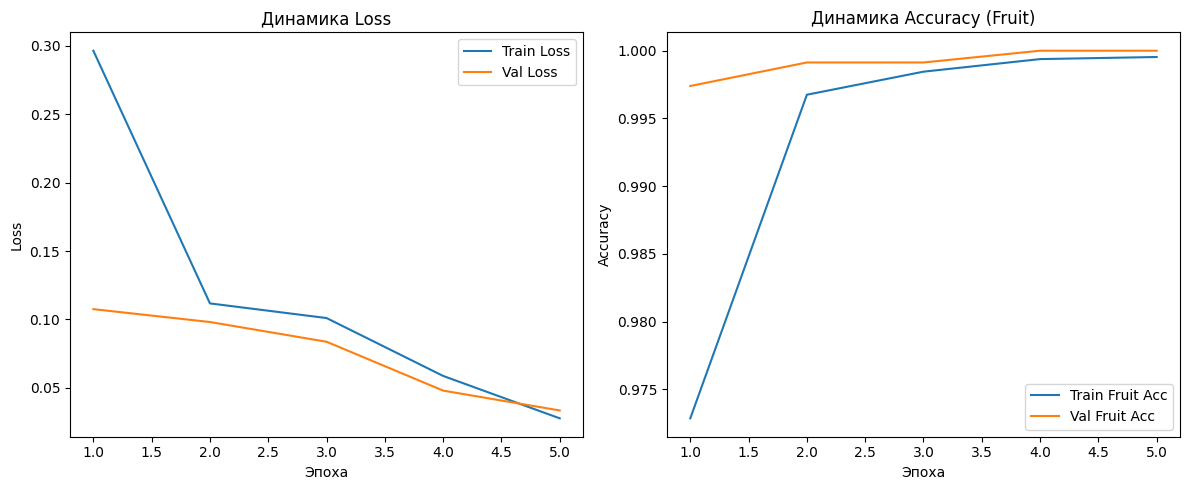

In [18]:
# Инициализируем мультизадачную модель
model_resnet = MultiTaskModel(resnet50_backbone, num_fruit_classes, num_freshness_classes)
model_resnet = model_resnet.to(device)

# Обучение модели (например, 5 эпох, первые 3 с замороженным backbone)
history_resnet = train_model(model_resnet, train_loader, val_loader, device, num_epochs=5, frozen_epochs=3)

# Оценка модели на тестовой выборке
metrics_resnet = evaluate_model(model_resnet, val_loader, device)

# Визуализация динамики обучения
epochs = range(1, len(history_resnet['train_loss'])+1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history_resnet['train_loss'], label='Train Loss')
plt.plot(epochs, history_resnet['val_loss'], label='Val Loss')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.legend()
plt.title("Динамика Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs, history_resnet['train_fruit_acc'], label='Train Fruit Acc')
plt.plot(epochs, history_resnet['val_fruit_acc'], label='Val Fruit Acc')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Динамика Accuracy (Fruit)")

plt.tight_layout()
plt.show()

Эпоха 1/5


Train batches:   0%|          | 0/101 [00:00<?, ?it/s]

Train Loss: 0.4075, Fruit Acc: 0.9630, Fresh Acc: 0.8883


Val batches:   0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.1778, Fruit Acc: 0.9892, Fresh Acc: 0.9445

Эпоха 2/5


Train batches:   0%|          | 0/101 [00:00<?, ?it/s]

Train Loss: 0.2403, Fruit Acc: 0.9818, Fresh Acc: 0.9243


Val batches:   0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.1517, Fruit Acc: 0.9944, Fresh Acc: 0.9467

Эпоха 3/5


Train batches:   0%|          | 0/101 [00:00<?, ?it/s]

Train Loss: 0.1843, Fruit Acc: 0.9847, Fresh Acc: 0.9482


Val batches:   0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.1069, Fruit Acc: 0.9961, Fresh Acc: 0.9662

Эпоха 4/5
Разморозка весов backbone...


Train batches:   0%|          | 0/101 [00:00<?, ?it/s]

Train Loss: 0.1040, Fruit Acc: 0.9929, Fresh Acc: 0.9675


Val batches:   0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.0521, Fruit Acc: 1.0000, Fresh Acc: 0.9814

Эпоха 5/5


Train batches:   0%|          | 0/101 [00:00<?, ?it/s]

Train Loss: 0.0590, Fruit Acc: 0.9975, Fresh Acc: 0.9789


Val batches:   0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.0336, Fruit Acc: 1.0000, Fresh Acc: 0.9853



Test batches:   0%|          | 0/18 [00:00<?, ?it/s]

Метрики для классификации фруктов/овощей:
Точность: 1.0000
Полнота: 1.0000
F1-score: 1.0000
Матрица ошибок:
[[297   0   0   0]
 [  0 297   0   0]
 [  0   0 241   0]
 [  0   0   0 297]]

Метрики для классификации свежести:
Точность: 0.9859
Полнота: 0.9858
F1-score: 0.9859
Матрица ошибок:
[[548   9]
 [  7 568]]


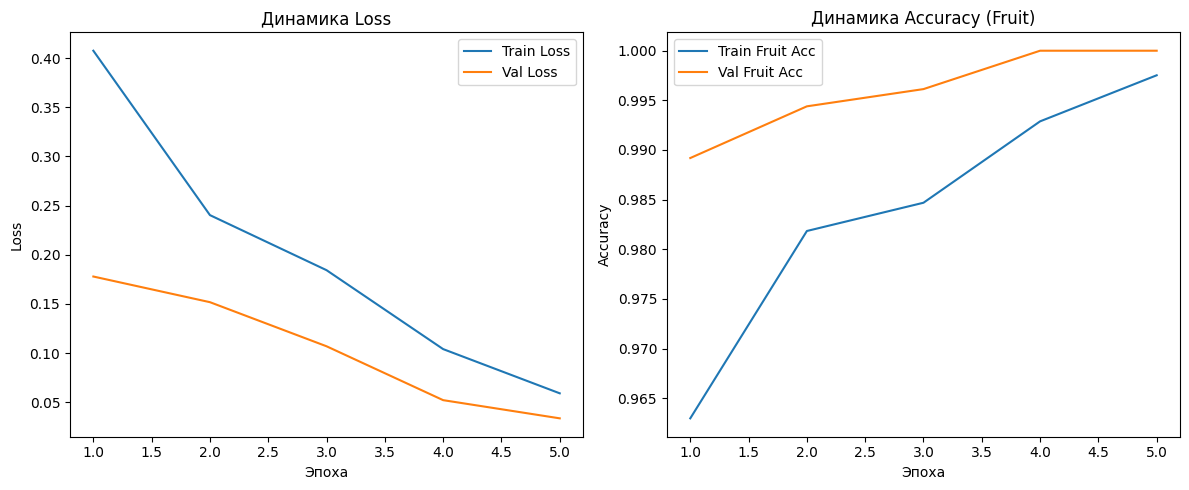

In [21]:
# Инициализируем мультизадачную модель
model_efficientnet = MultiTaskModel(efficientnet_b3_backbone, num_fruit_classes, num_freshness_classes)
model_efficientnet = model_efficientnet.to(device)

# Обучение модели (например, 5 эпох, первые 3 с замороженным backbone)
history_efficientnet = train_model(model_efficientnet, train_loader, val_loader, device, num_epochs=5, frozen_epochs=3)

# Оценка модели на тестовой выборке
metrics_efficientnet = evaluate_model(model_efficientnet, val_loader, device)

# Визуализация динамики обучения
epochs = range(1, len(history_efficientnet['train_loss'])+1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history_efficientnet['train_loss'], label='Train Loss')
plt.plot(epochs, history_efficientnet['val_loss'], label='Val Loss')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.legend()
plt.title("Динамика Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs, history_efficientnet['train_fruit_acc'], label='Train Fruit Acc')
plt.plot(epochs, history_efficientnet['val_fruit_acc'], label='Val Fruit Acc')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Динамика Accuracy (Fruit)")

plt.tight_layout()
plt.show()

Эпоха 1/5


Train batches:   0%|          | 0/101 [00:00<?, ?it/s]

Train Loss: 0.3662, Fruit Acc: 0.9651, Fresh Acc: 0.8900


Val batches:   0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.4238, Fruit Acc: 0.9289, Fresh Acc: 0.8778

Эпоха 2/5


Train batches:   0%|          | 0/101 [00:00<?, ?it/s]

Train Loss: 0.1644, Fruit Acc: 0.9936, Fresh Acc: 0.9438


Val batches:   0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.1755, Fruit Acc: 0.9905, Fresh Acc: 0.9332

Эпоха 3/5


Train batches:   0%|          | 0/101 [00:00<?, ?it/s]

Train Loss: 0.1056, Fruit Acc: 0.9961, Fresh Acc: 0.9619


Val batches:   0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.1348, Fruit Acc: 0.9922, Fresh Acc: 0.9528

Эпоха 4/5
Разморозка весов backbone...


Train batches:   0%|          | 0/101 [00:00<?, ?it/s]

Train Loss: 0.0733, Fruit Acc: 0.9991, Fresh Acc: 0.9748


Val batches:   0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.0569, Fruit Acc: 0.9991, Fresh Acc: 0.9775

Эпоха 5/5


Train batches:   0%|          | 0/101 [00:00<?, ?it/s]

Train Loss: 0.0310, Fruit Acc: 0.9997, Fresh Acc: 0.9895


Val batches:   0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.0357, Fruit Acc: 0.9991, Fresh Acc: 0.9836



Test batches:   0%|          | 0/18 [00:00<?, ?it/s]

Метрики для классификации фруктов/овощей:
Точность: 0.9991
Полнота: 0.9992
F1-score: 0.9991
Матрица ошибок:
[[297   0   0   0]
 [  0 297   0   0]
 [  0   0 241   0]
 [  0   0   1 296]]

Метрики для классификации свежести:
Точность: 0.9841
Полнота: 0.9842
F1-score: 0.9841
Матрица ошибок:
[[553   4]
 [ 14 561]]


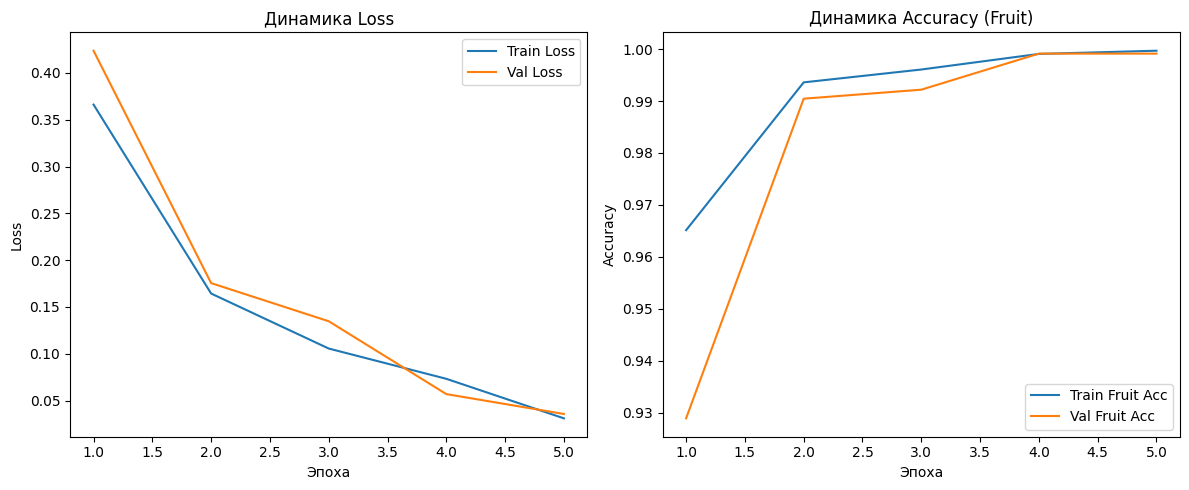

In [27]:
# Инициализируем мультизадачную модель
model_mobilenet = MultiTaskModel(mobilenet_v3_backbone, num_fruit_classes, num_freshness_classes)
model_mobilenet = model_mobilenet.to(device)

# Обучение модели (например, 5 эпох, первые 3 с замороженным backbone)
history_mobilenet = train_model(model_mobilenet, train_loader, val_loader, device, num_epochs=5, frozen_epochs=3)

# Оценка модели на тестовой выборке
metrics_mobilenet = evaluate_model(model_mobilenet, val_loader, device)

# Визуализация динамики обучения
epochs = range(1, len(history_mobilenet['train_loss'])+1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history_mobilenet['train_loss'], label='Train Loss')
plt.plot(epochs, history_mobilenet['val_loss'], label='Val Loss')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.legend()
plt.title("Динамика Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs, history_mobilenet['train_fruit_acc'], label='Train Fruit Acc')
plt.plot(epochs, history_mobilenet['val_fruit_acc'], label='Val Fruit Acc')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Динамика Accuracy (Fruit)")

plt.tight_layout()
plt.show()